In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def plot_line(x, y):
    sns.lineplot(x=x, y=y)

    plt.show()


def visualize_quantity(f, a, b, discrete='n'):
    if discrete == 'n':
        x = np.linspace(a, b)
    else:
        x = list(range(int(a), int(b)))

    y = [f(x_) for x_ in x]
    plot_line(x=x, y=y)

In [58]:
from scipy.stats import binom, gamma
from Operator import Operator

# binom params
n = 30
p = .2
operator = Operator()
operator.create_quantity('s1', pdf=gamma.pdf, cdf=gamma.cdf, sample=gamma.rvs, kwargs={'a': 10, 'scale': 200},
                         domain_type='c')
operator.create_quantity('s2', pdf=gamma.pdf, cdf=gamma.cdf, sample=gamma.rvs, kwargs={'a': 10, 'scale': 200},
                         domain_type='c')
operator.create_quantity('n_sales', binom.pmf, cdf=binom.cdf, sample=binom.rvs, kwargs={'n': 30, 'p': .2},
                         domain_type='d')

operator.create_cc_convolution(conv_name='s3', c_quantity1=operator.quantities['s1'], c_quantity2=operator.quantities['s2'], operation='*')

/Users/nieminm42/codeprojects/financial-modeling/Distribution.py:78: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(self.integrand, 0, z, (z,), epsabs=1e-9, epsrel=1e-9)


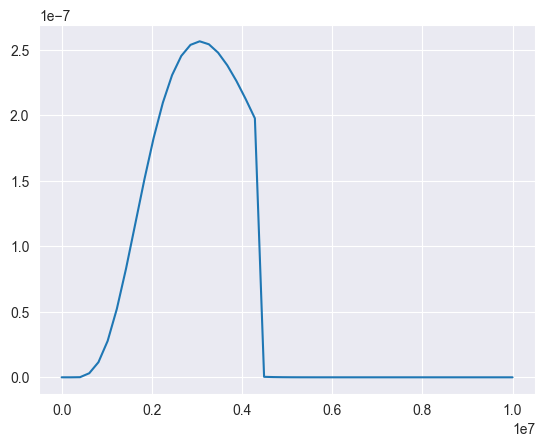

In [59]:
from scipy import integrate

# operator.visualize_quantity(operator.quantities['s3'].cdf, 0, 20_000_000)
a, b = 0, 10_000_000
z = 10000
operator.visualize_quantity(operator.quantities['s3'].cdf, a, b)
# integrate.quad(operator.quantities['s3'].cdf, a, b)[0]

# print(operator.quantities['s3'].cdf(1_000_000) > operator.quantities['s3'].cdf(2_000_000))

In [60]:
integrate.quad(operator.quantities['s3'].pdf, 0, b*20)#, epsabs=1e-12, epsrel=1e-12)

(1.1907821328309168e-32, 5.6228215392302266e-33)

In [61]:
z = 10_000_000
integrate.quad(lambda x: gamma.pdf(x, a=10, scale=2000) * gamma.pdf(z / x, a=10, scale=2000) * (1 / np.abs(x)), 0, z)

(5.401254931707033e-17, 1.0739344137545699e-16)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy as sp

interp1d = sp.interpolate.interp1d
trapezoid = sp.integrate.trapezoid

# Time domain vector - needed in class
dt = 0.01
t_max = 10
T = np.arange(dt, t_max + dt, dt)

# Distance domain vector - needed in class
dd = 0.01
d_max = 10_000_000
D = np.arange(0, d_max + dd, dd)

class MultiplicativeModel(stats.rv_continuous):
    def __init__(self, Tmodel, Vmodel, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.Tmodel = Tmodel # The time-domain probability function
        self.Vmodel = Vmodel # The velocity-domain probability function

        # Create vectors for interpolation of distributions        
        self.pdf_vec = np.array([trapezoid(self.Tmodel.pdf(T) * \
                                       self.Vmodel.pdf(_ / T) / T, dx = dt) \
                                 for _ in D])
        self.cdf_vec = np.cumsum(self.pdf_vec) * dd
        self.sf_vec = 1 - self.cdf_vec

        # define key functions for rv_continuous class
        self._pdf = interp1d(D, self.pdf_vec, assume_sorted=True)        
        self._sf = interp1d(D, self.sf_vec, assume_sorted=True)        
        self._cdf = interp1d(D, self.cdf_vec, assume_sorted=True)

        # Extraolation option below is necessary because sometimes rvs picks 
        # a number really really close to 1 or 0 and this spits out an error if it
        # is outside of the interpolation range.        
        self._ppf = interp1d(self.cdf_vec, D, assume_sorted=True, 
                             fill_value = 'extrapolate')
        # Moments
        self._munp = lambda n, *args: np.trapz(self.pdf_vec * D ** n, dx=dd)

In [63]:
dv = 0.01
v_max = 10
V = np.arange(0, v_max + dv, dv)

model = MultiplicativeModel(stats.gamma(a=10, scale=2000),
                            stats.gamma(a=10, scale=2000))


# test moments and stats functions
print(f'median: {model.median()}')
# median: 8.700970199181763
print(f'moments: {model.stats(moments = "mvsk")}')
#moments: (array(9.00872026), array(12.2315612), array(0.44131568), array(0.16819043))

plt.figure(figsize=(6,4))
plt.plot(T, model.Tmodel.pdf(T), label = 'Time PDF')
plt.plot(V, model.Vmodel.pdf(V), label = 'Velocity PDF')
plt.plot(D, model.pdf(D), label = 'Distance PDF')
plt.plot(D, model.cdf(D), label = 'Distance CDF')
plt.plot(D, model.sf(D), label = 'Distance SF')

x = model.rvs(size=10**5)
plt.hist(x, bins = 50, density = True, alpha = 0.5, label = 'Sampled distribution')
plt.legend()
plt.xlim([0,30])

KeyboardInterrupt: 